# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.48866 CV = 0.463102
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

Versão 1.0.1: LB = 0.48991 CV = 0.462946
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com novas features)

Versão 1.0.2: LB = ???? CV = 0.464442
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com agrupamento pela coluna v2)

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

# Importa pacotes do sklearn
#from sklearn.ensemble import RandomForestClassifier
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import log_loss
#from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler


# Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_modificado_v2.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_modificado_v2.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 59 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 66 colunas


In [5]:
# Removendo algumas colunas do dataset de test
test = test[test.columns[:-8]]

In [6]:
# Juntando os dois dataset (treino e teste)
df = train.append(test)

In [7]:
df.head()

,target,v105_mean,v105_median,v108_min,v10_bin,v110,v111_median,v111_min,v113,v119_min,v121_max,v121_median,v129,v20_median_bin,v24,v26_median_bin,v3,v30,v31,v34_bin,v34_max_bin,v34_min_bin,v38,v39_min_bin,v40_bin,v40_max_bin,v40_min,v41_max,v46_max,v47,v50_bin,v50_max,v51_min,v54_max,v55_max,v56,v62,v63_max,v64_max,v64_median,v66,v67_max,v69_median,v71,v73_max,v74,v76_mean,v76_min,v79,v81_min,v85_median,v85_min,v89_min,v92_max,v92_median,v93_max,v94_median,v97_median,v98_min
0,0.0,0.433874,0.433874,0.087649,46,0,0.305085,0.305085,0,4.362469e-02,0.193461,0.193461,0,168,0,186,0,0,0,163,151,84,0,228,170,113,0.461923,0.441124,0.530565,0,267,0.066833,0.371055,0.239243,0.103033,0,1,0.554319,0.231768,0.231768,0,0.578947,0.403141,0,0.140440,0,0.082698,0.082698,0,0.347083,0.233202,0.233202,0.234489,0.109197,0.109197,0.268864,0.243951,0.603015,0.269968
1,1.0,0.053497,0.054048,0.024281,58,0,0.168266,0.168266,1,1.584485e-01,0.136880,0.136880,0,140,1,158,0,1,0,197,195,0,0,228,153,224,0.000000,0.359128,1.000000,1,390,1.000000,0.359908,1.000000,0.077978,1,1,1.000000,0.317186,0.317186,1,0.464364,0.472467,1,0.121665,0,0.120253,0.120253,1,0.122814,0.141113,0.141113,0.001503,0.065260,0.065260,0.273759,0.202609,0.381128,0.032490
2,1.0,0.011025,0.011025,0.091884,58,0,0.307095,0.307095,0,6.085414e-02,0.250472,0.250472,0,68,2,3,0,-1,0,97,97,48,0,228,211,127,0.737386,0.319449,0.016759,2,375,0.103734,0.548206,0.012371,0.118602,2,1,0.017624,0.165429,0.165429,0,0.413343,0.435798,1,0.150334,0,0.054539,0.054539,2,0.450263,0.295019,0.295019,0.015960,0.054982,0.054982,0.201919,0.199744,0.263333,0.571295
3,0.0,0.053497,0.054048,0.024281,35,0,0.168266,0.168266,0,1.584485e-01,0.136880,0.136880,0,140,1,158,0,-1,0,97,195,0,0,228,211,224,0.000000,0.359128,1.000000,1,27,1.000000,0.359908,1.000000,0.077978,-1,2,1.000000,0.317186,0.317186,2,0.464364,0.472467,1,0.121665,0,0.120253,0.120253,3,0.122814,0.141113,0.141113,0.001503,0.065260,0.065260,0.273759,0.202609,0.381128,0.032490
4,1.0,0.000471,0.000471,0.089153,52,1,0.198582,0.198582,-1,6.891533e-08,0.115385,0.115385,0,171,0,12,0,-1,1,142,142,80,6,117,198,127,0.518561,0.401891,0.001554,3,390,0.129998,0.328848,0.006728,0.056738,3,0,0.003511,0.279553,0.279553,1,0.482270,0.363636,1,0.081699,1,0.093716,0.093716,4,0.405371,0.070313,0.070313,0.001603,0.071066,0.071066,0.263183,0.155371,0.333333,0.368675


# Algoritmo LigthGBM com Hyperparametros

In [8]:
# Buscando os melhores parametros
# Utilizei o Hyperopt para otimizacao e o metodo Bayesian Optimization Primer
import json
from pandas.io.json import json_normalize

with open('trials.json') as file_data:
    trial_json = json.load(file_data)

data = json_normalize(trial_json)
data.head(3).T

,0,1,2
loss,0.263423,0.26411,0.264141
iteration,17,15,2
train_time,1.99563,0.874582,0.860642
status,ok,ok,ok
hyperparameters.boosting_type,gbdt,gbdt,gbdt
hyperparameters.colsample_bytree,0.881783,0.972798,0.895936
hyperparameters.is_unbalance,True,True,True
hyperparameters.learning_rate,0.0129388,0.0408052,0.0361298
hyperparameters.min_child_samples,315,450,415
hyperparameters.num_leaves,139,48,87


In [26]:
# Configurações Gerais

GENERATE_SUBMISSION_FILES = True
SUBMISSION_SUFIX = "_lgbm_v.1.0.2"
STRATIFIED_KFOLD = False
RANDOM_SEED = np.random.seed(737851)
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 100

# Selecionando os melhores parametros
LIGHTGBM_PARAMS: {'boosting_type': 'gbdt', 
                  'colsample_bytree': 0.881783, 
                  'is_unbalance': False, 
                  'learning_rate': 0.0129388, 
                  'min_child_samples': 315, 
                  'num_leaves': 139, 
                  'reg_alpha': 0.484807, 
                  'reg_lambda': 0.515065, 
                  'subsample_for_bin': 280000, 
                  'subsample': 0.635119, 
                  'n_estimators': 10000
                 }

"LIGHTGBM_PARAMS = {\n    'boosting_type': 'goss',\n    'n_estimators': 10000,\n    'learning_rate': 0.005134,\n    'num_leaves': 54,\n    'max_depth': 10,\n    'subsample_for_bin': 240000,\n    'reg_alpha': 0.436193,\n    'reg_lambda': 0.479169,\n    'colsample_bytree': 0.508716,\n    'min_split_gain': 0.024766,\n    'subsample': 1,\n    'is_unbalance': False,\n    'silent':-1,\n    'verbose':-1\n}"

In [27]:
# ------------------------- LIGHTGBM MODEL -------------------------
# Funcao para processar todo o pipeline do treinamento e gerar a submissao
def run_model(data, categorical_feature = None):
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    del_features = ['target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        
        if not categorical_feature:
            clf.fit(train_x, train_y, 
                    eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', 
                    verbose=400, 
                    early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, 
                    eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', 
                    verbose=400, 
                    early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), 
                    categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds))
    test['target'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Save submission (test data) and feature importance
        submission = pd.read_csv('../dataset/sample_submission.csv')
        submission['PredictedProb'] = sub_preds.copy()
        submission.to_csv('../submission/submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
        plt.hist(submission.PredictedProb)
        plt.show()
    
    return mean_importance

Train/valid shape: (114321, 59), test shape: (114393, 59)
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.470441	valid_1's binary_logloss: 0.482471
[800]	training's binary_logloss: 0.455049	valid_1's binary_logloss: 0.475194
[1200]	training's binary_logloss: 0.445318	valid_1's binary_logloss: 0.472863
[1600]	training's binary_logloss: 0.437121	valid_1's binary_logloss: 0.471791
[2000]	training's binary_logloss: 0.429802	valid_1's binary_logloss: 0.471196
[2400]	training's binary_logloss: 0.42309	valid_1's binary_logloss: 0.470535
Early stopping, best iteration is:
[2461]	training's binary_logloss: 0.422099	valid_1's binary_logloss: 0.470458
Fold  1 Log Loss : 0.470458
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.470424	valid_1's binary_logloss: 0.479882
[800]	training's binary_logloss: 0.4551	valid_1's binary_logloss: 0.472734
[1200]	training's binary_logloss: 0.445393	valid_1's binary_

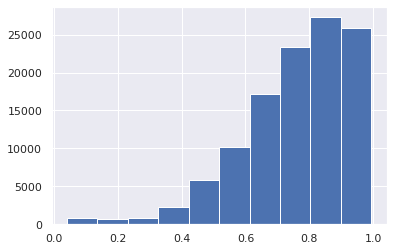

,feature,gain,split
29,v50_bin,869799.033019,9639.4
39,v66,255882.758619,3050.6
34,v56,226627.105562,6335.9
30,v50_max,193771.280479,4525.4
3,v10_bin,182036.239951,5515.2
23,v40_bin,145499.201866,4301.8
17,v31,137965.984701,819.7
41,v69_median,131598.713927,4615.0
43,v73_max,130512.278291,4625.2
8,v119_min,129134.655203,4518.7


In [28]:
run_model(df)